This notebook was created by Donna Faith Go.

In [1]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# webscraping
import requests
from bs4 import BeautifulSoup

# data gathering
import yfinance as yf
import time
import pandas_datareader.data as web
from datetime import datetime, timedelta

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# dynamic time warping
from dtaidistance import dtw
from sklearn.preprocessing import StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Comparison of Chinese Stocks and Philippine Stocks

## Data Gathering

In [2]:
# getting closing prices for the 30 stocks with batching
start_date = '2000-01-01'
end_date = '2026-01-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

In [3]:
# # Download the philippine index
# closing_df = download_stocks_in_batches(
#     ['PSEI.PS'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/philippine index.pkl')

In [4]:
# # Download the chinese and philippine indices
# chinese_indices = [
#     # mainland china
#     '000001.SS', '399001.SZ', '399006.SZ', '000300.SS',
#     '000905.SS', '000852.SS', '399673.SZ', '000016.SS',
#     '000688.SS',
    
#     # hong kong
#     '^HSI', '^HSCE', '^HSCC', '^HSTECH', 'GOVT.HK',
    
#     # taiwan
#     '^TWII', '^TPEx', '0050.TW', '006208.TW',
    
#     # singapore
#     'STI.SI', 'F3E.SI', 'XINA50.SI',
    
#     # us chinese etfs
#     'FXI', 'KWEB', 'CQQQ', 'MCHI', 'GXC',
# ]

# closing_df = download_stocks_in_batches(
#     chinese_indices, 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/chinese indices.pkl')

In [5]:
# store data in variables
filepath = r'data/chinese indices.pkl'
with open(filepath, 'rb') as f:
    chinese_data = pickle.load(f)

filepath = r'data/philippine index.pkl'
with open(filepath, 'rb') as f:
    psei_data = pickle.load(f)

# remove the invalid tickers
chinese_data.dropna(how='all', axis=1, inplace=True)
psei_data.dropna(how='all', axis=1, inplace=True)

## Data Preprocessing

### null handling

In [6]:
# dropping all weekends
chinese_data.dropna(how='all', axis=0, inplace=True)
psei_data.dropna(how='all', axis=0, inplace=True)

# # ensure they have the same indices
# chinese_data = chinese_data.loc[psei_data.index.intersection(chinese_data.index)]

## Dynamic Time Warping

### yearly dtw

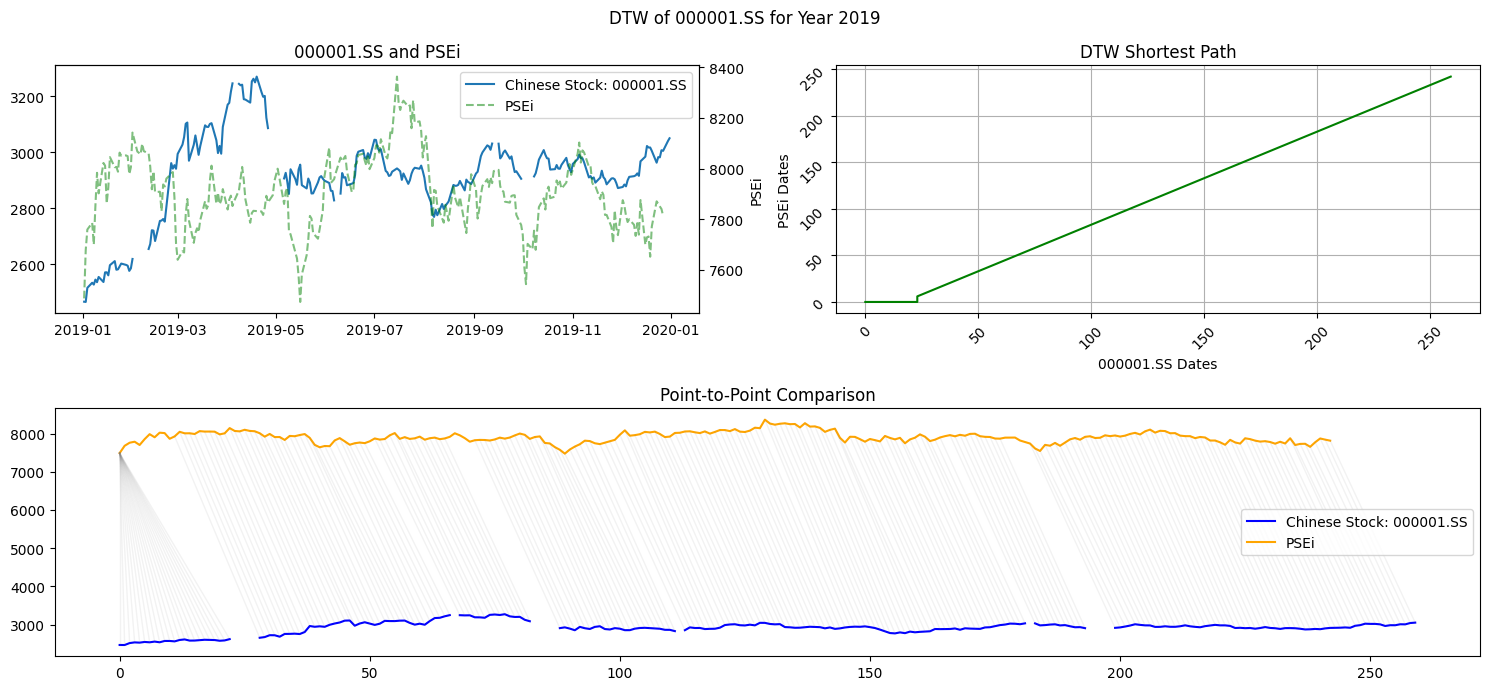

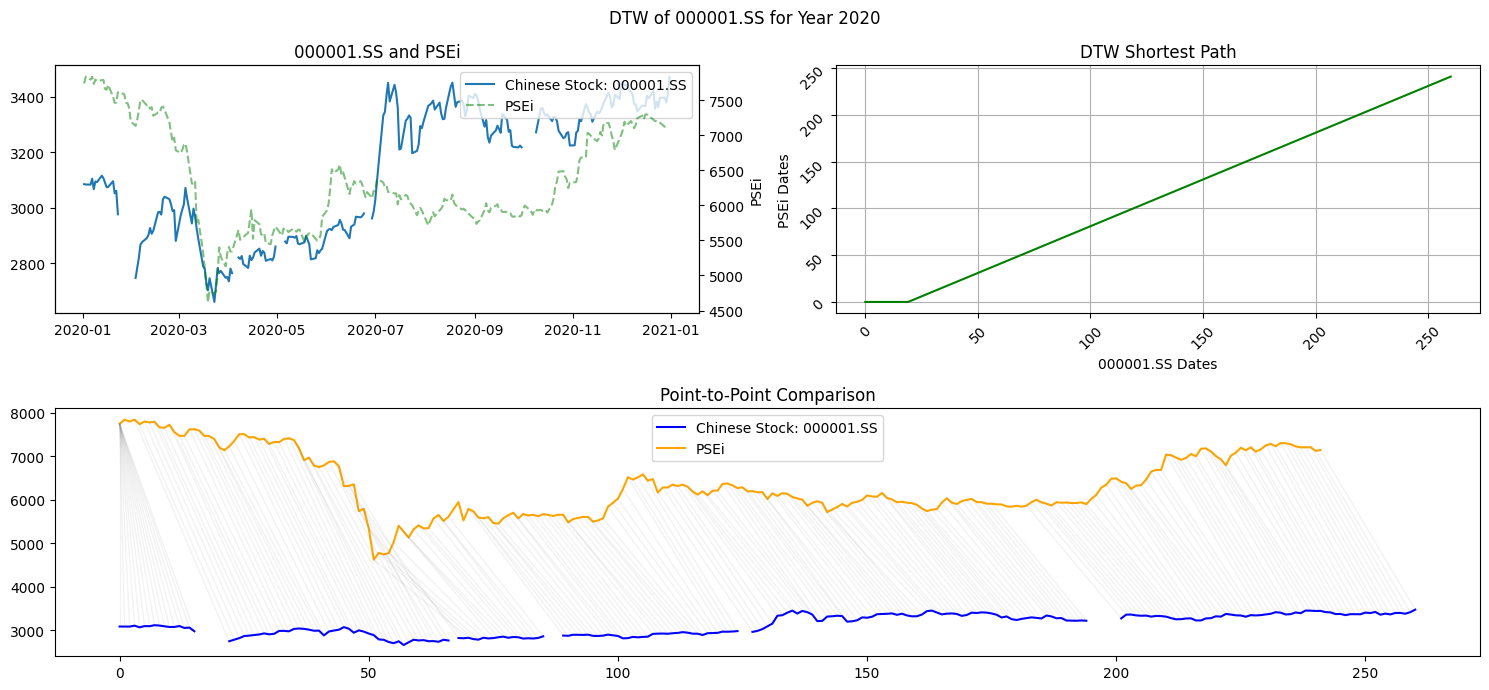

In [10]:
# declare years to inspect
all_years = [str(year) for year in range(2000, 2026)]
interesting_years = ['2019', '2020'] #'2015', '2016', '2019', '2020', '2021']

for year in interesting_years: 
    for col in chinese_data.columns:
        # temporary variable for data to be comapred
        chinese_compare = chinese_data[col].loc[year]
        psei_compare = psei_data.loc[year]
        
        # dynamic time warping
        distance, paths = dtw.warping_paths(
            chinese_compare.values, psei_compare.values, 
            use_c=False
        )
        best_path = dtw.best_path(paths)
        similarity_score = distance / len(best_path)
        
        # plotting
        fig = plt.figure(figsize=(15, 7))
        
        # l1 norms
        ax1 = plt.subplot2grid((2, 2), (0, 0))
        ax1.plot(chinese_compare, label=f'Chinese Stock: {col}')
        
        # vix 
        ax2 = ax1.twinx()
        ax2.plot(psei_compare, label="PSEi", alpha=0.5, color='green', linestyle='--')
        ax2.set_ylabel('PSEi')
        
        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
        ax1.set_title(f'{col} and PSEi')
    
        # dtw shortest path
        ax3 = plt.subplot2grid((2, 2), (0, 1))
        path = np.array(best_path)
        ax3.plot(path[:, 0], path[:, 1], color='green',)
        ax3.set_title('DTW Shortest Path')
        ax3.set_xlabel(f'{col} Dates')
        ax3.set_ylabel('PSEi Dates')
        ax3.grid(True)    
        ax3.tick_params(axis='x', rotation=45)
        ax3.tick_params(axis='y', rotation=45)
    
        # point to point alignment
        time_series_a = chinese_compare.values.flatten()
        time_series_b = psei_compare.values.flatten()
        
        ax4 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        ax4.plot(time_series_a, label=f'Chinese Stock: {col}', color='blue')
        ax4.plot(time_series_b, label='PSEi', color='orange')
        for a, b in best_path:
            ax4.plot(
                [a, b], [time_series_a[a], time_series_b[b]], 
                color='grey', linestyle='-', linewidth=1, alpha = 0.1
            )
        ax4.set_title('Point-to-Point Comparison')
        ax4.legend()
    
        title = f'DTW of {col} for Year {year}'
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()
        break

### covid dtw

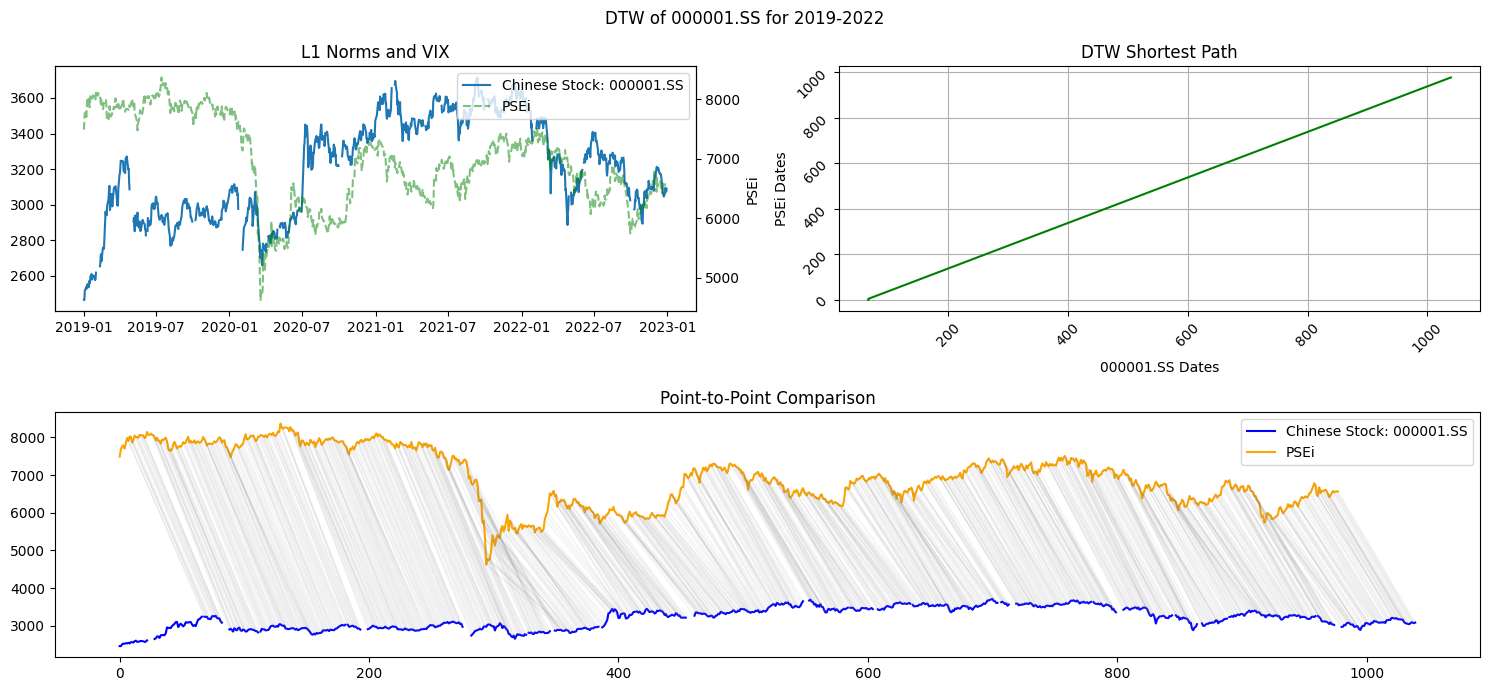

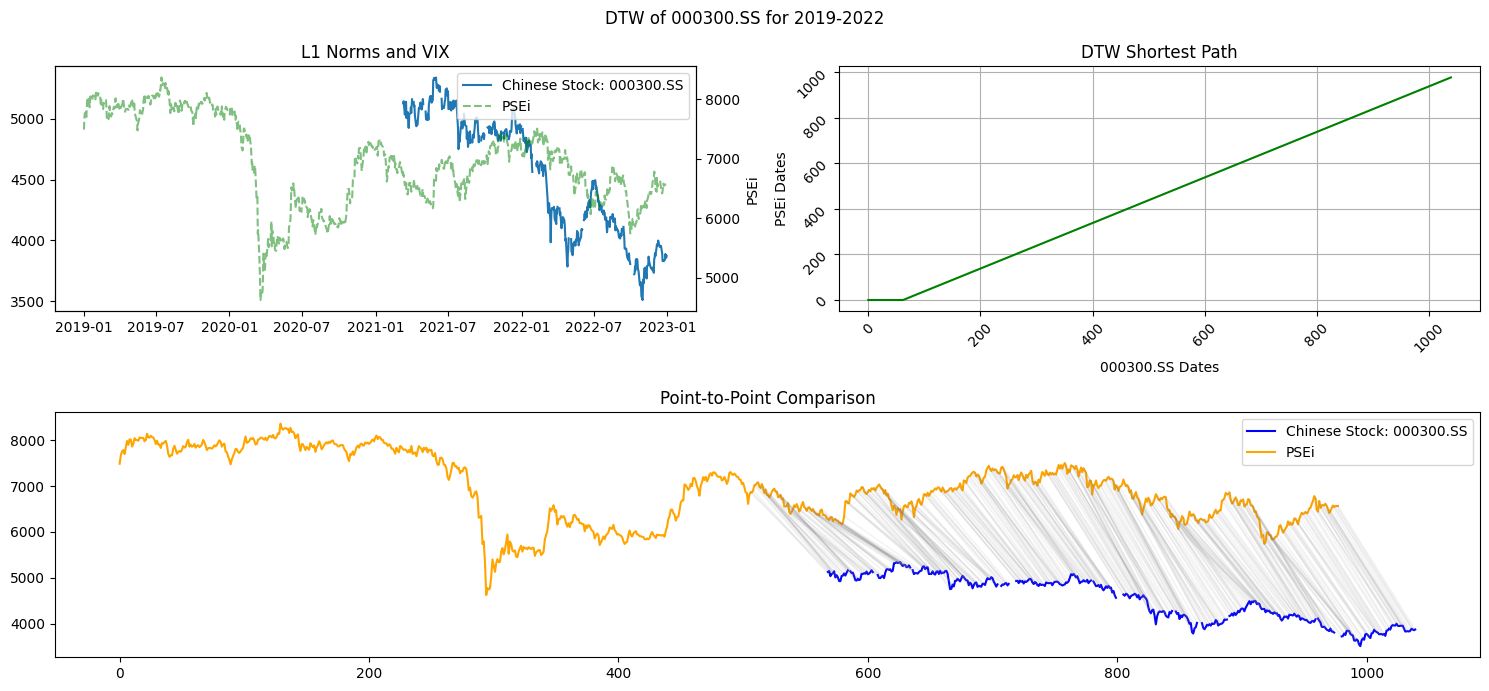

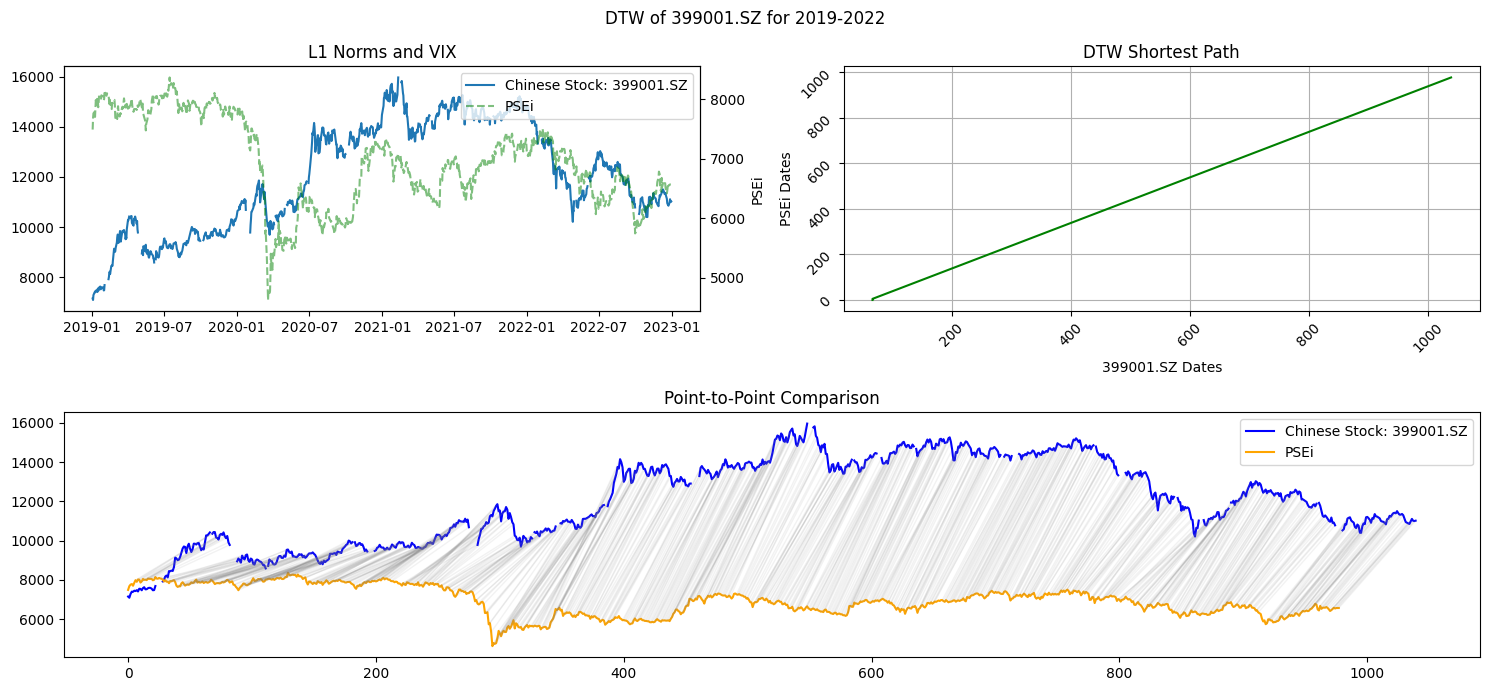

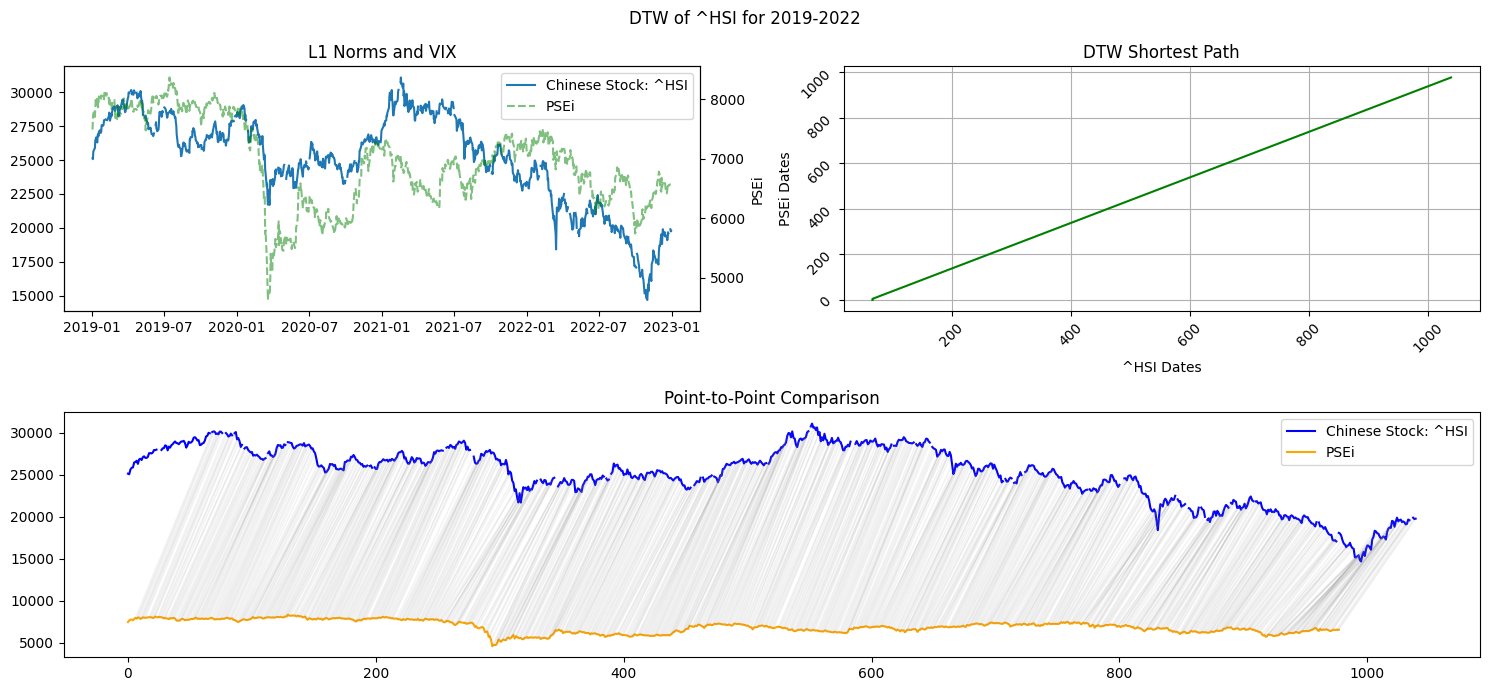

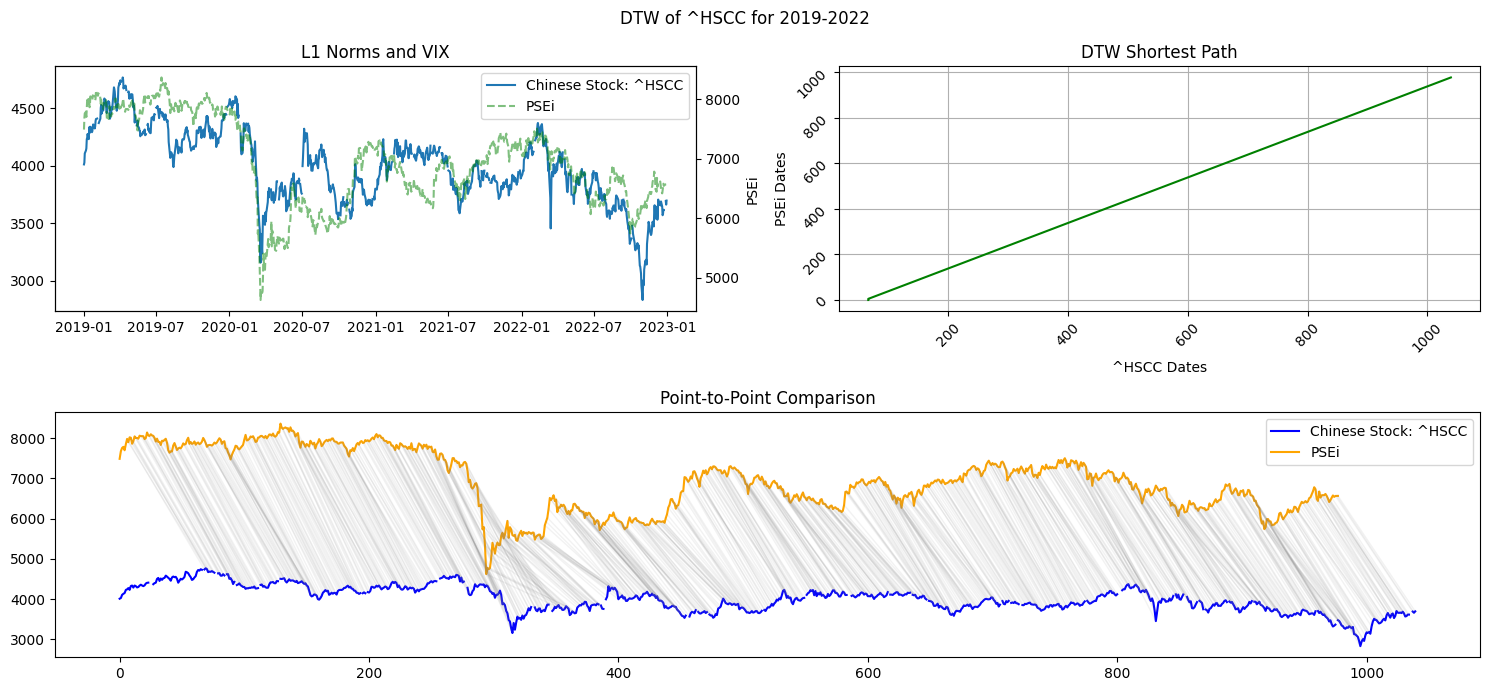

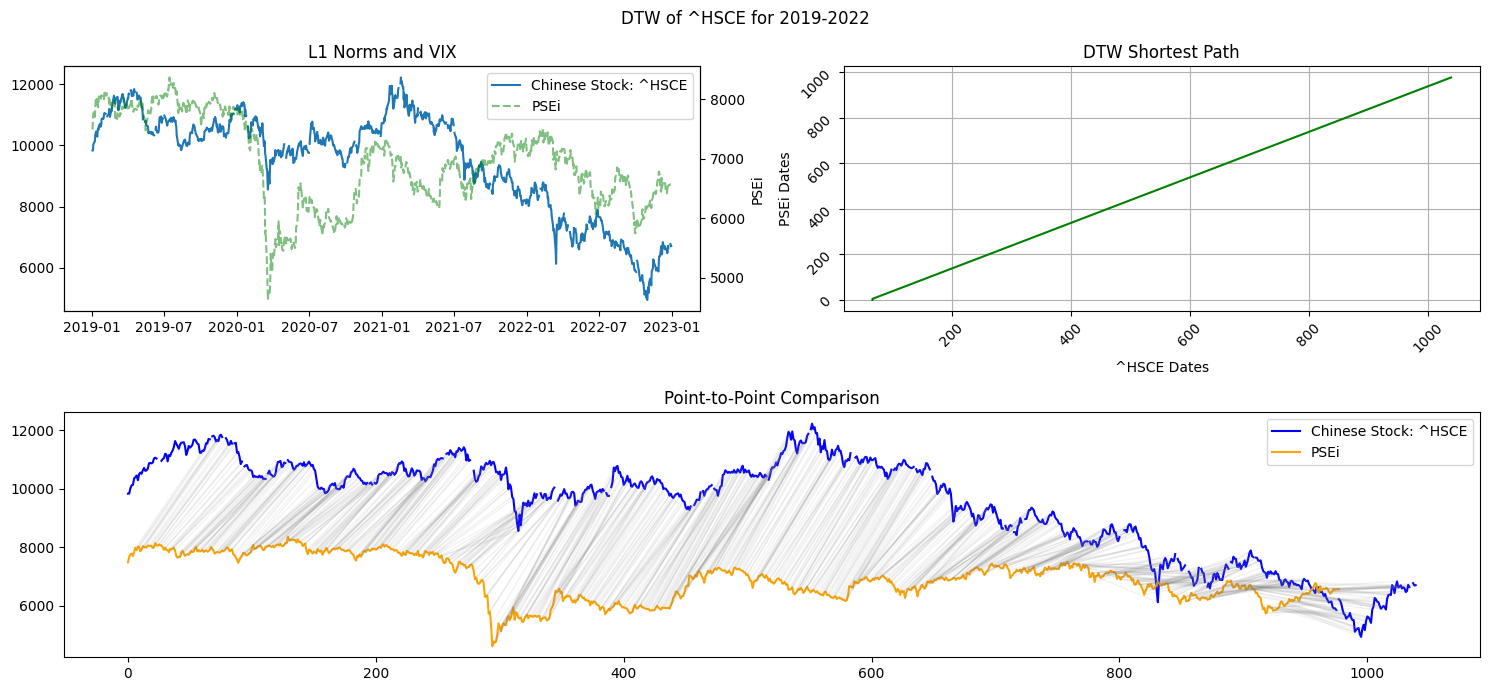

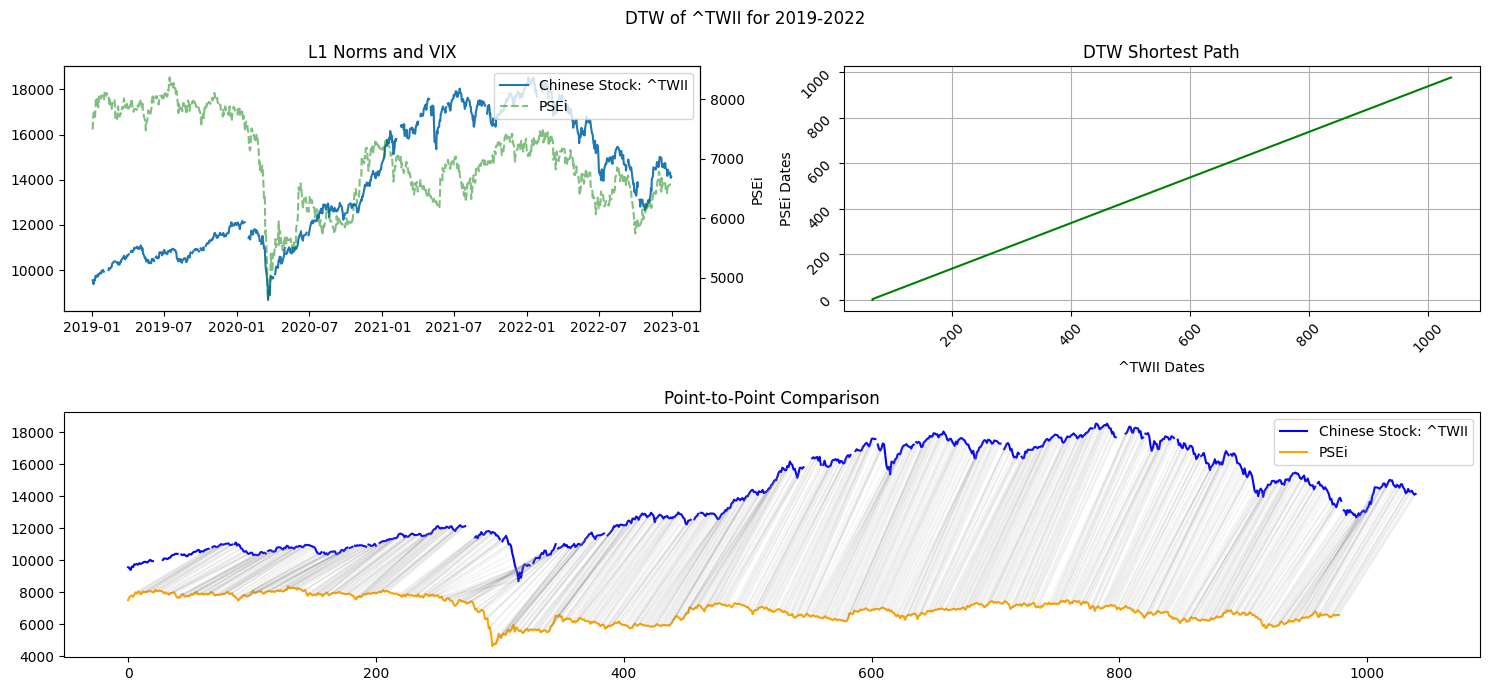

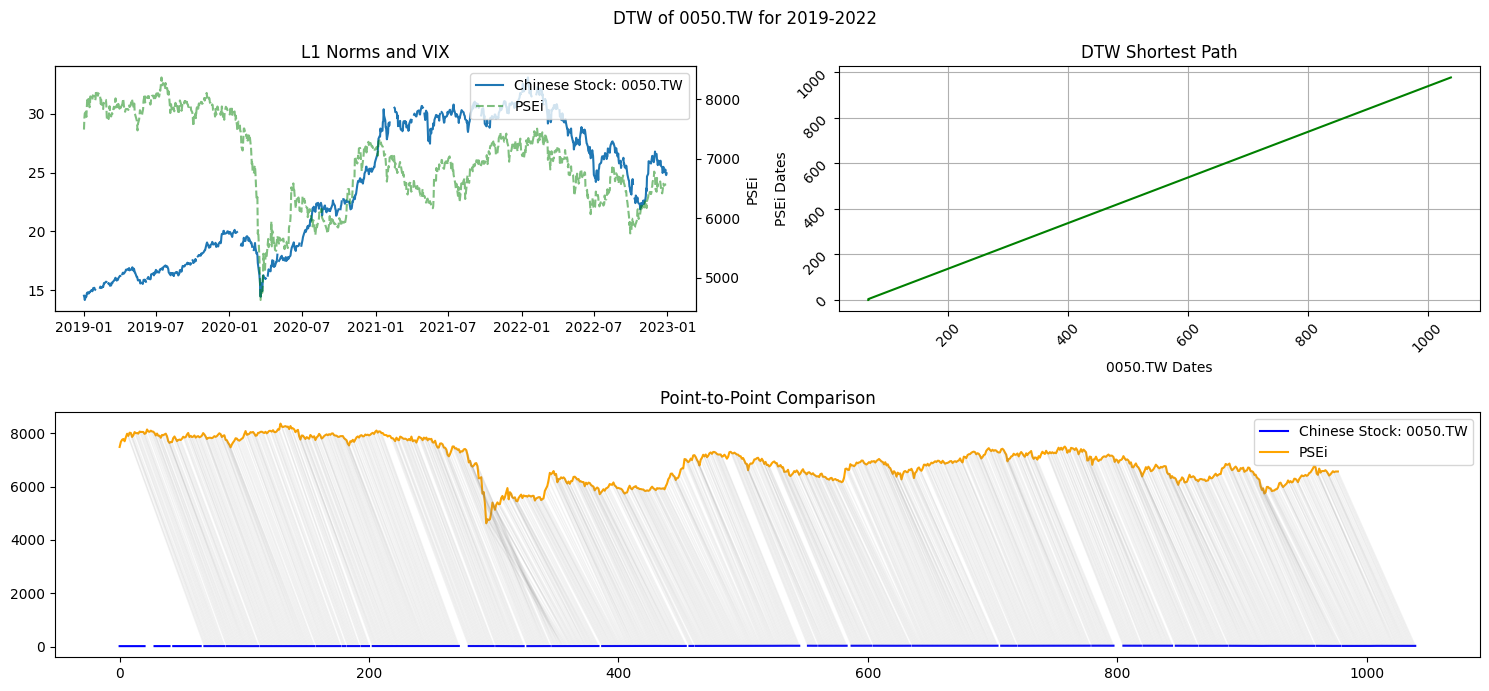

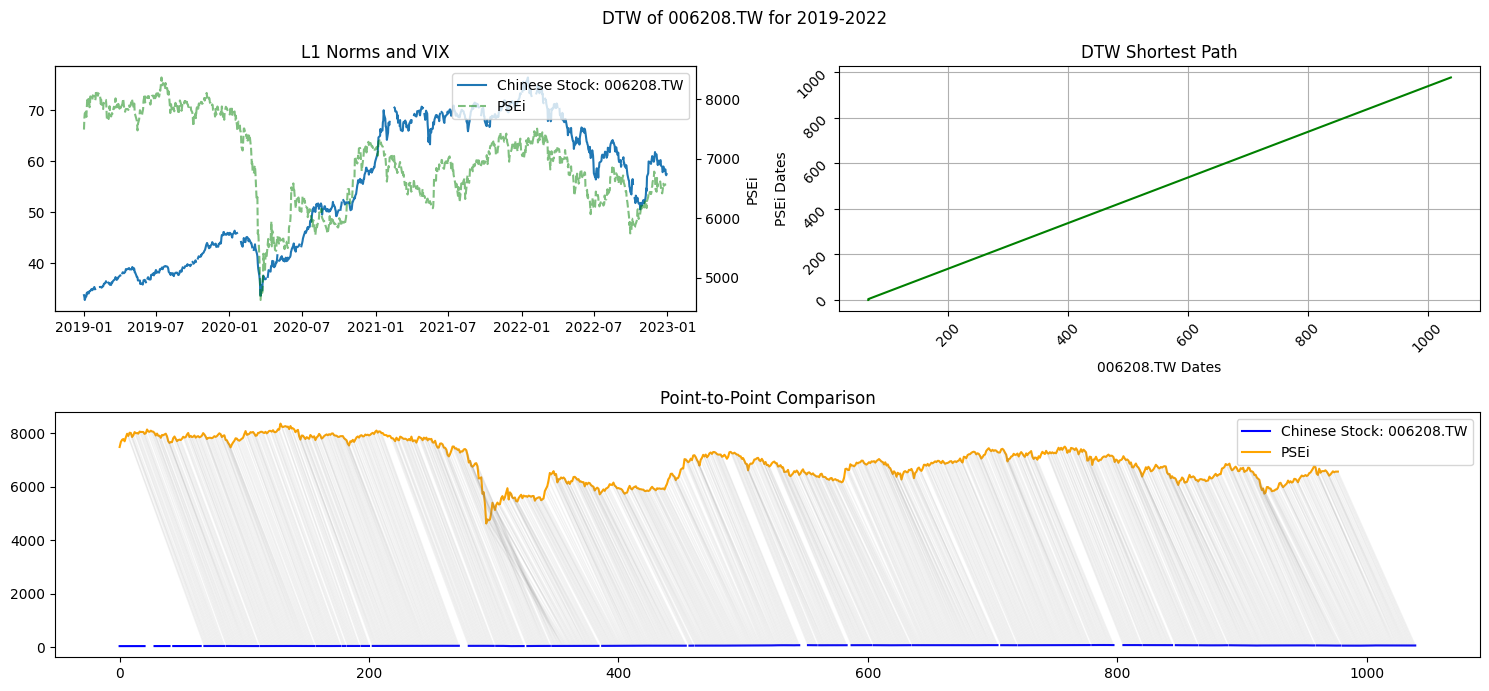

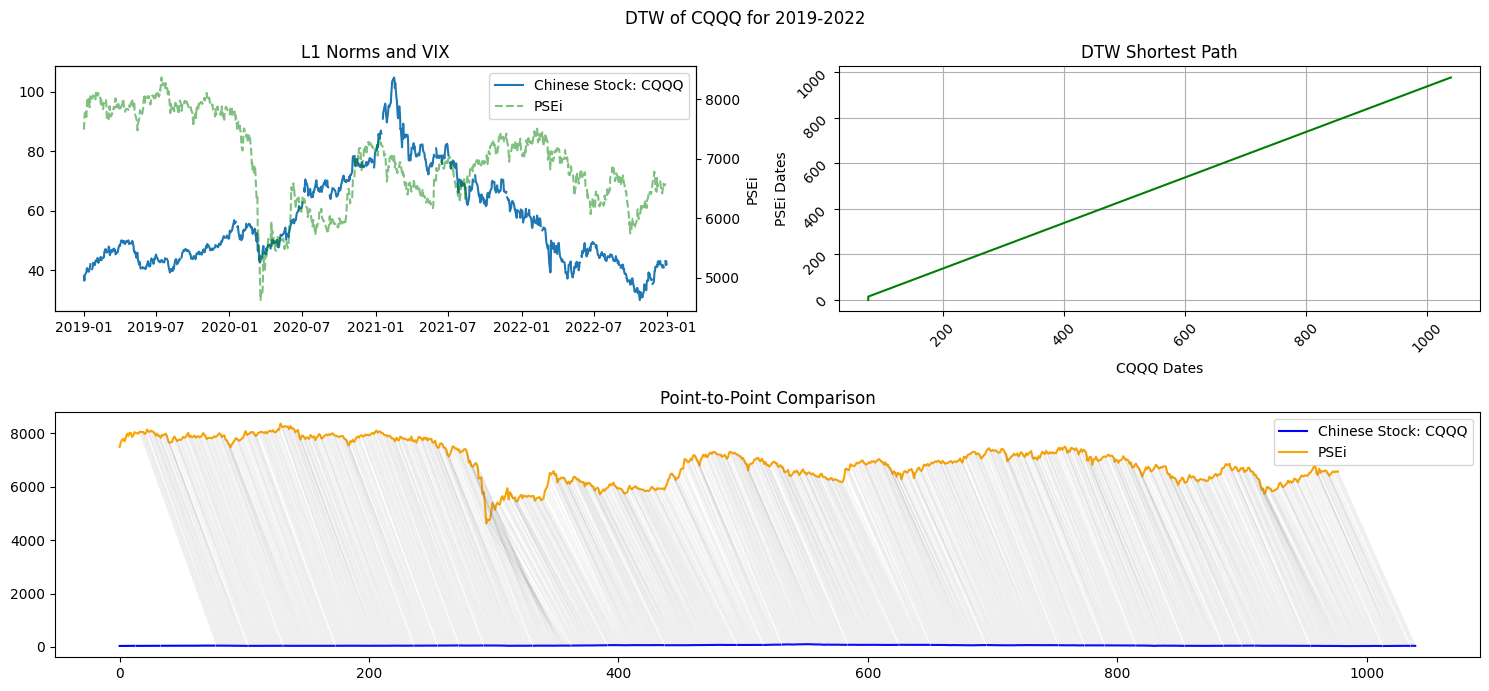

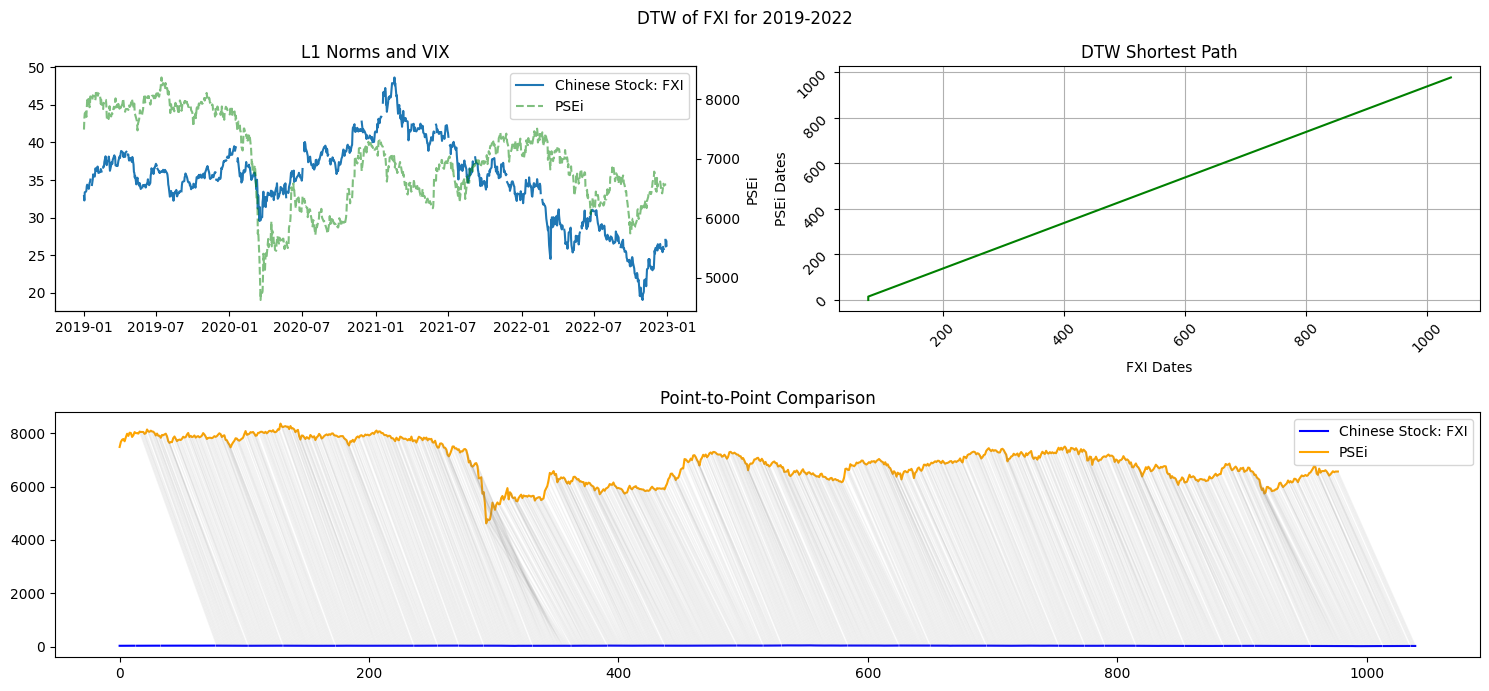

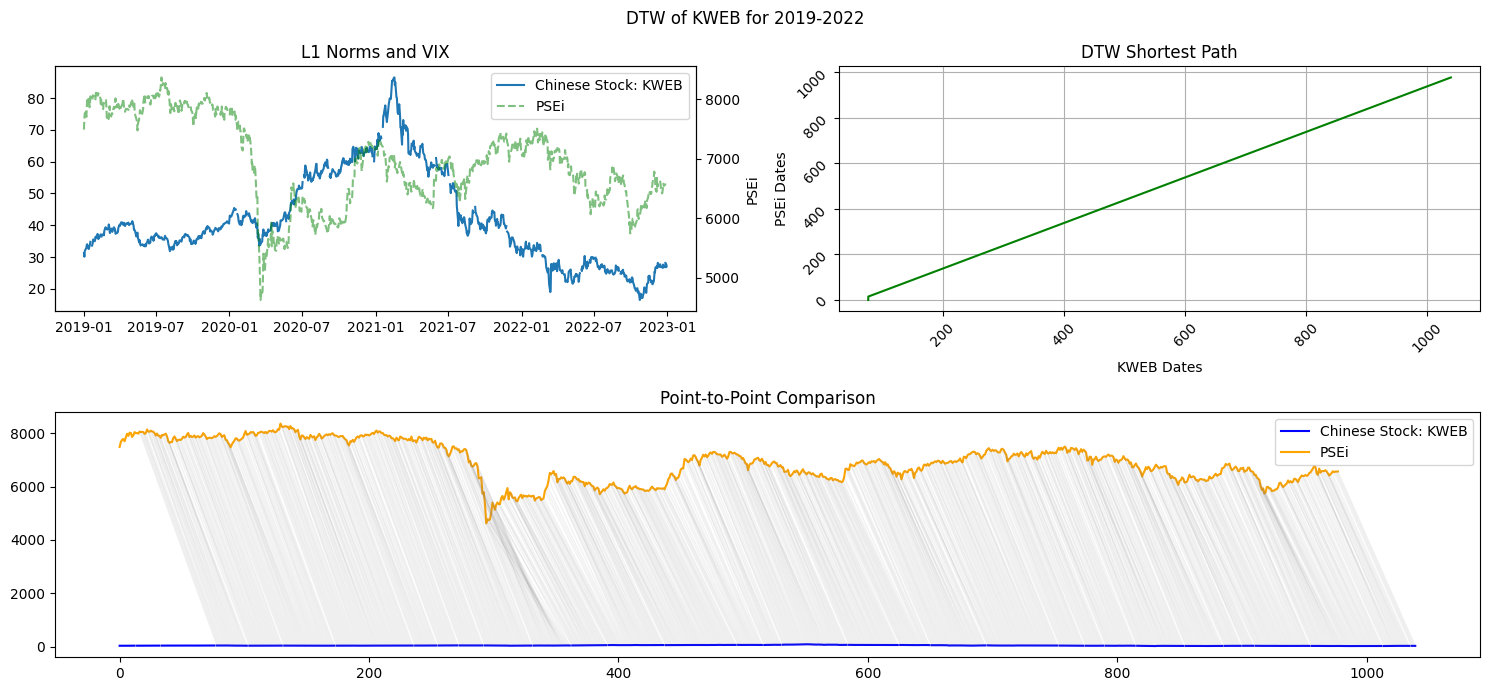

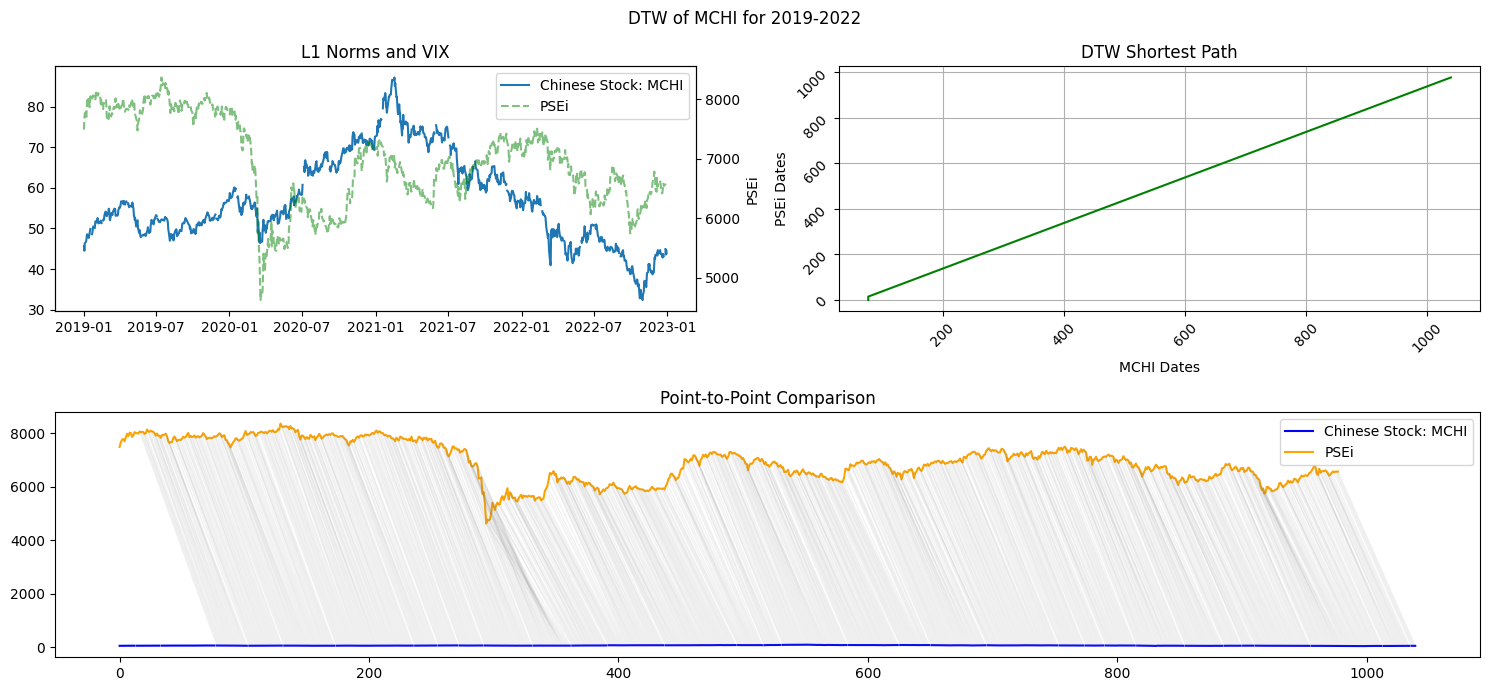

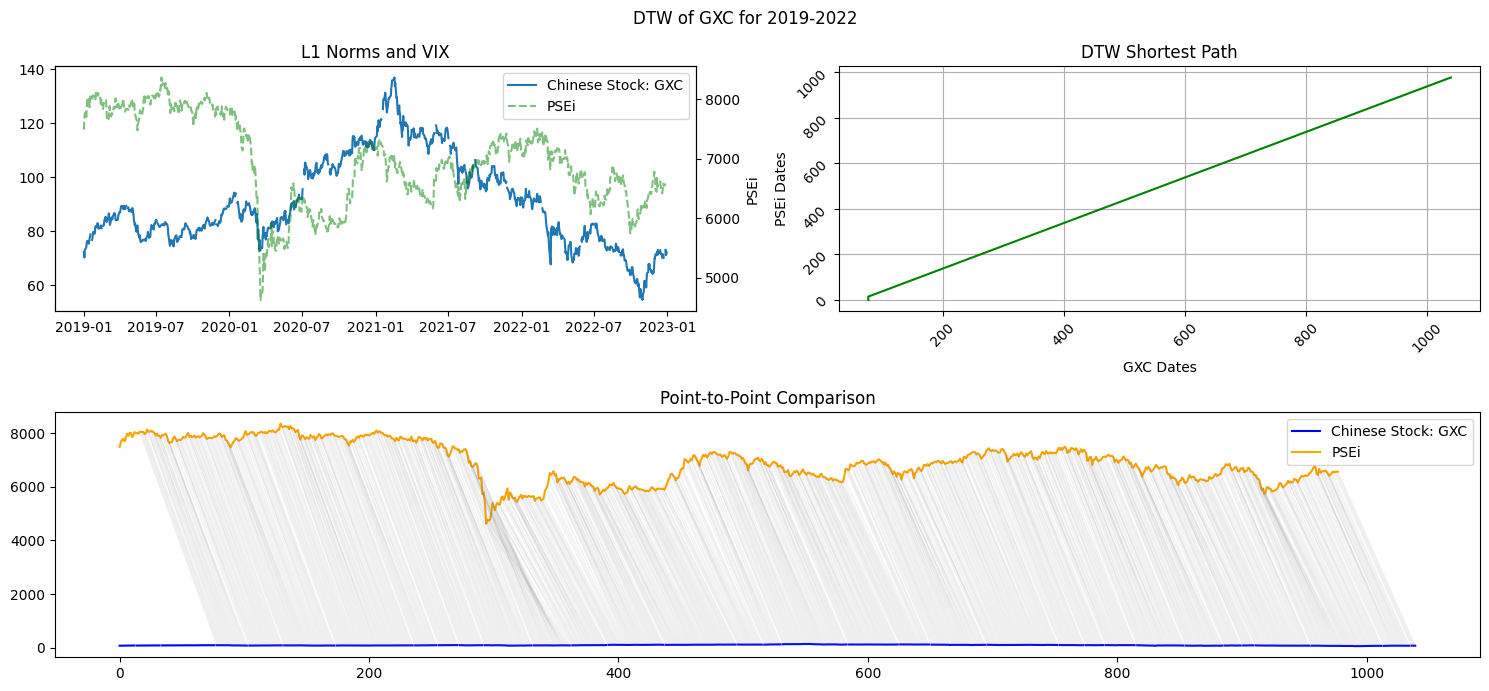

In [11]:
for col in chinese_data.columns:
    # temporary variable for data to be comapred
    chinese_compare = chinese_data[col].loc['2019':'2022']
    psei_compare = psei_data.loc['2019':'2022']
    
    # dynamic time warping
    distance, paths = dtw.warping_paths(
        chinese_compare.values, psei_compare.values, 
        use_c=False
    )
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)
    
    # plotting
    fig = plt.figure(figsize=(15, 7))
    
    # l1 norms
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.plot(chinese_compare, label=f'Chinese Stock: {col}')
    
    # vix 
    ax2 = ax1.twinx()
    ax2.plot(psei_compare, label="PSEi", alpha=0.5, color='green', linestyle='--')
    ax2.set_ylabel('PSEi')
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    ax1.set_title('L1 Norms and VIX')

    # dtw shortest path
    ax3 = plt.subplot2grid((2, 2), (0, 1))
    path = np.array(best_path)
    ax3.plot(path[:, 0], path[:, 1], color='green',)
    ax3.set_title('DTW Shortest Path')
    ax3.set_xlabel(f'{col} Dates')
    ax3.set_ylabel('PSEi Dates')
    ax3.grid(True)    
    ax3.tick_params(axis='x', rotation=45)
    ax3.tick_params(axis='y', rotation=45)

    # point to point alignment
    time_series_a = chinese_compare.values.flatten()
    time_series_b = psei_compare.values.flatten()
    
    ax4 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    ax4.plot(time_series_a, label=f'Chinese Stock: {col}', color='blue')
    ax4.plot(time_series_b, label='PSEi', color='orange')
    for a, b in best_path:
        ax4.plot(
            [a, b], [time_series_a[a], time_series_b[b]], 
            color='grey', linestyle='-', linewidth=1, alpha = 0.1
        )
    ax4.set_title('Point-to-Point Comparison')
    ax4.legend()

    title = f'DTW of {col} for 2019-2022'
    fig.suptitle(title)
    plt.tight_layout()
    plt.show() 

### 2015-2016 dtw

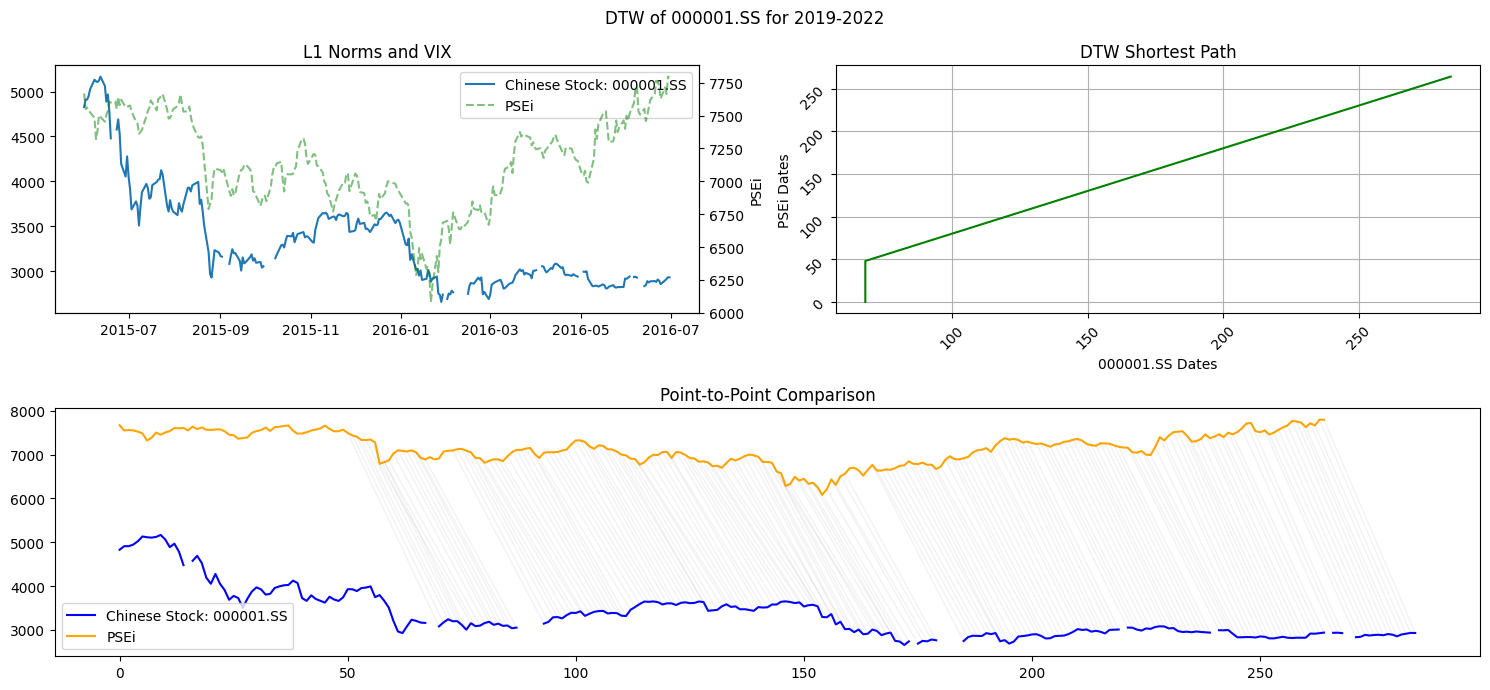

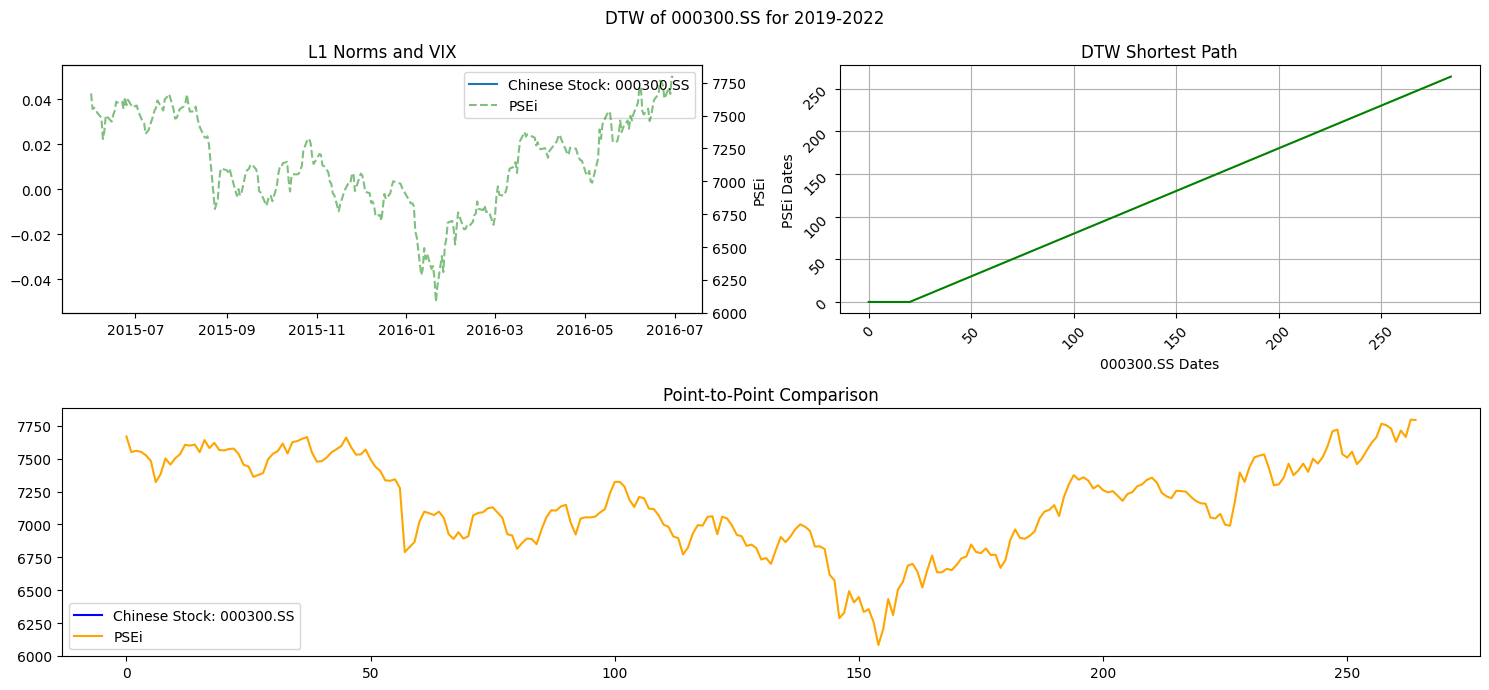

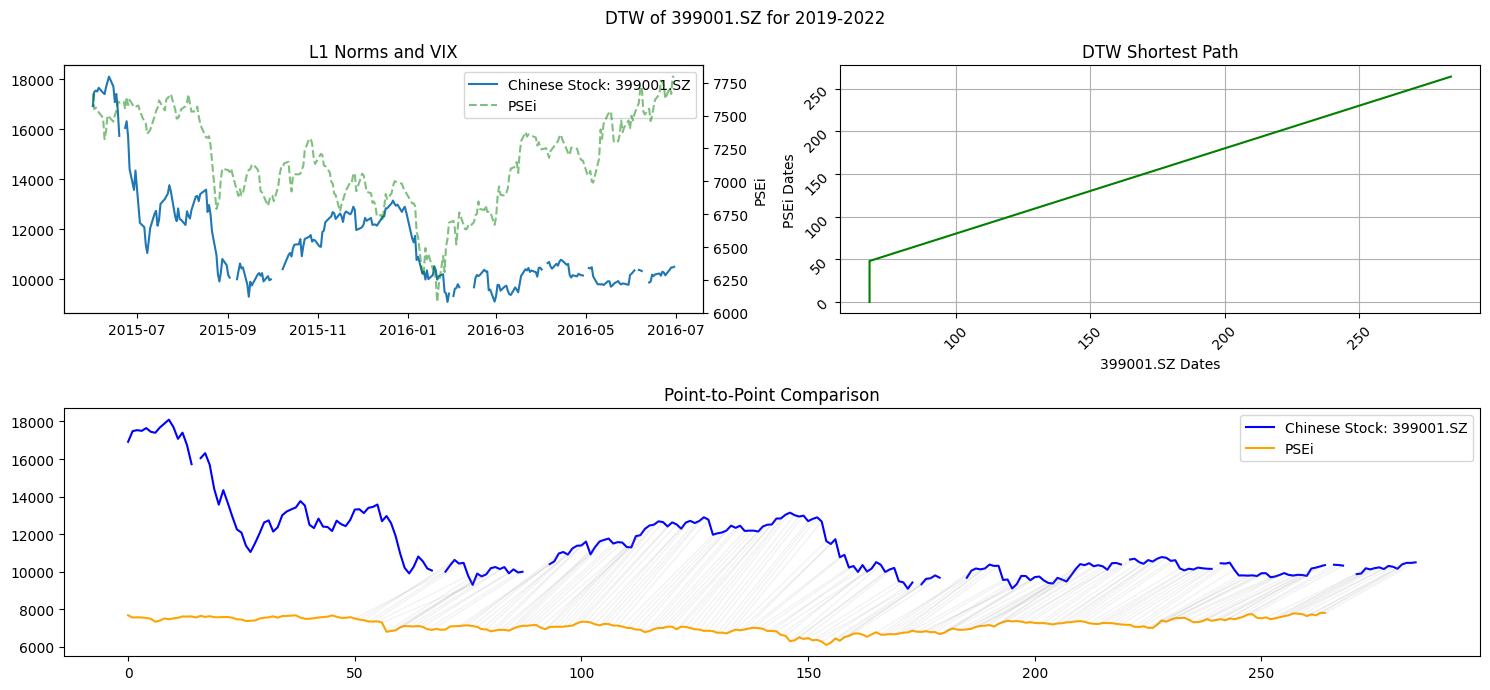

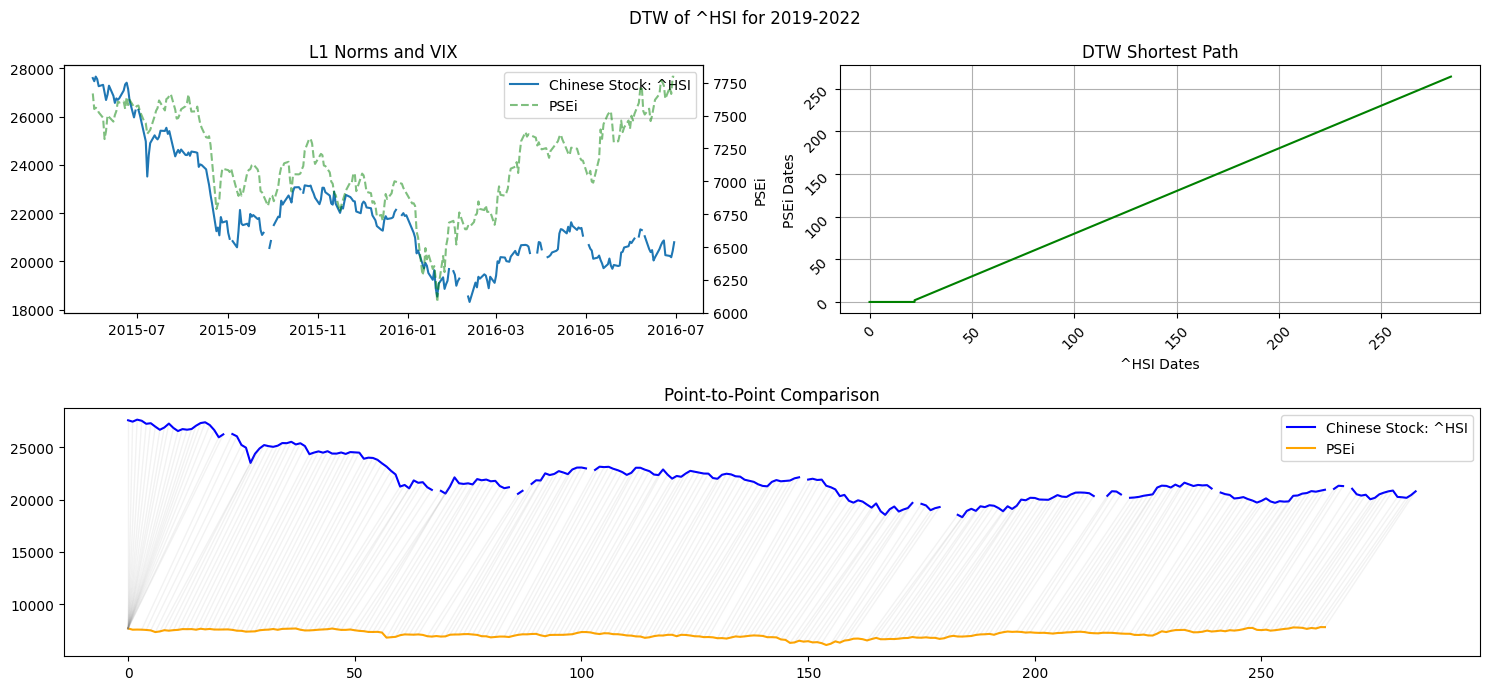

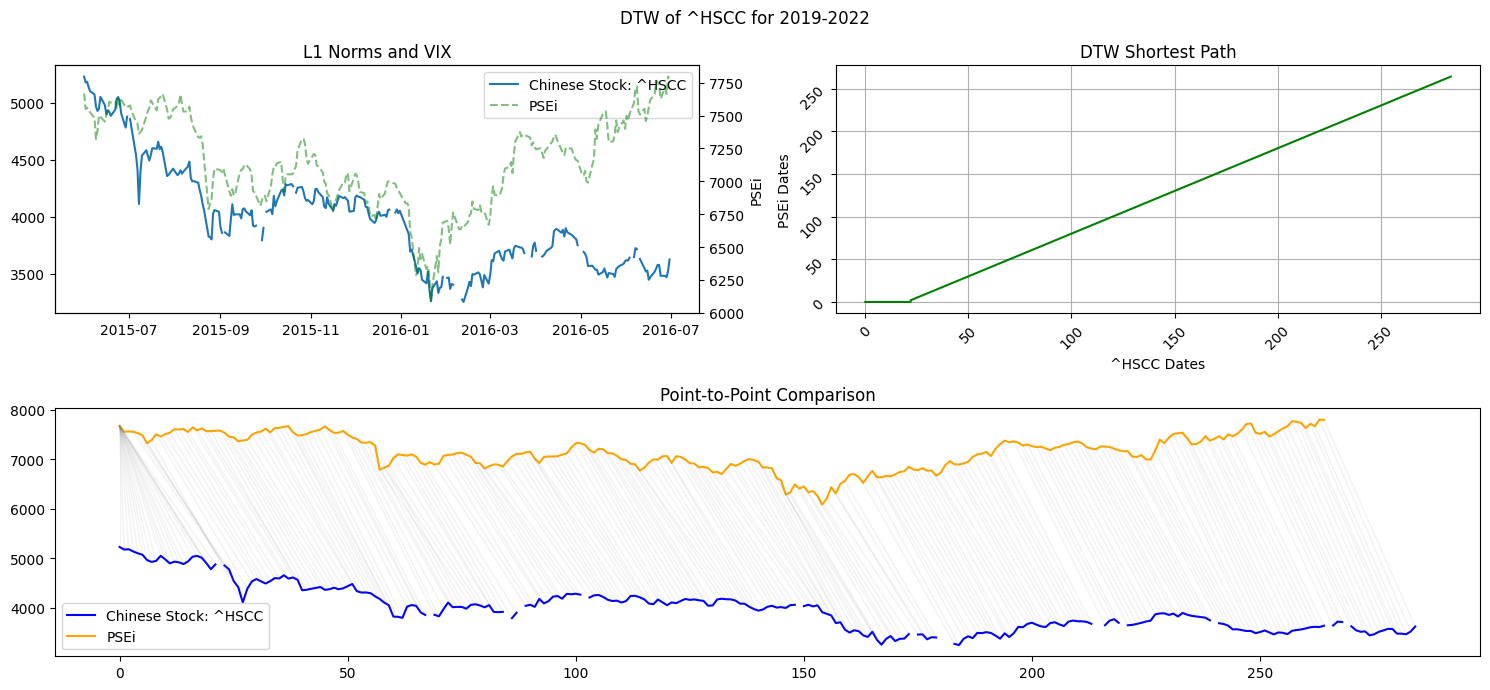

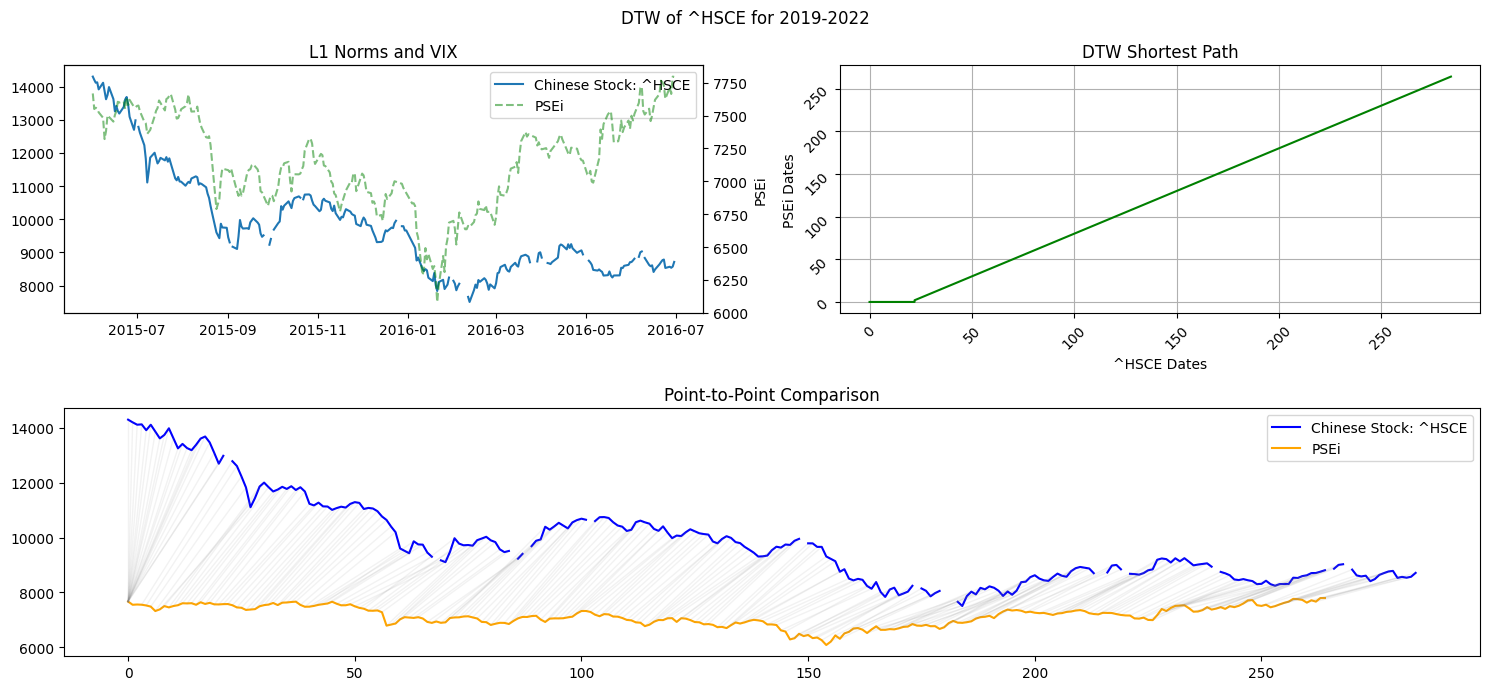

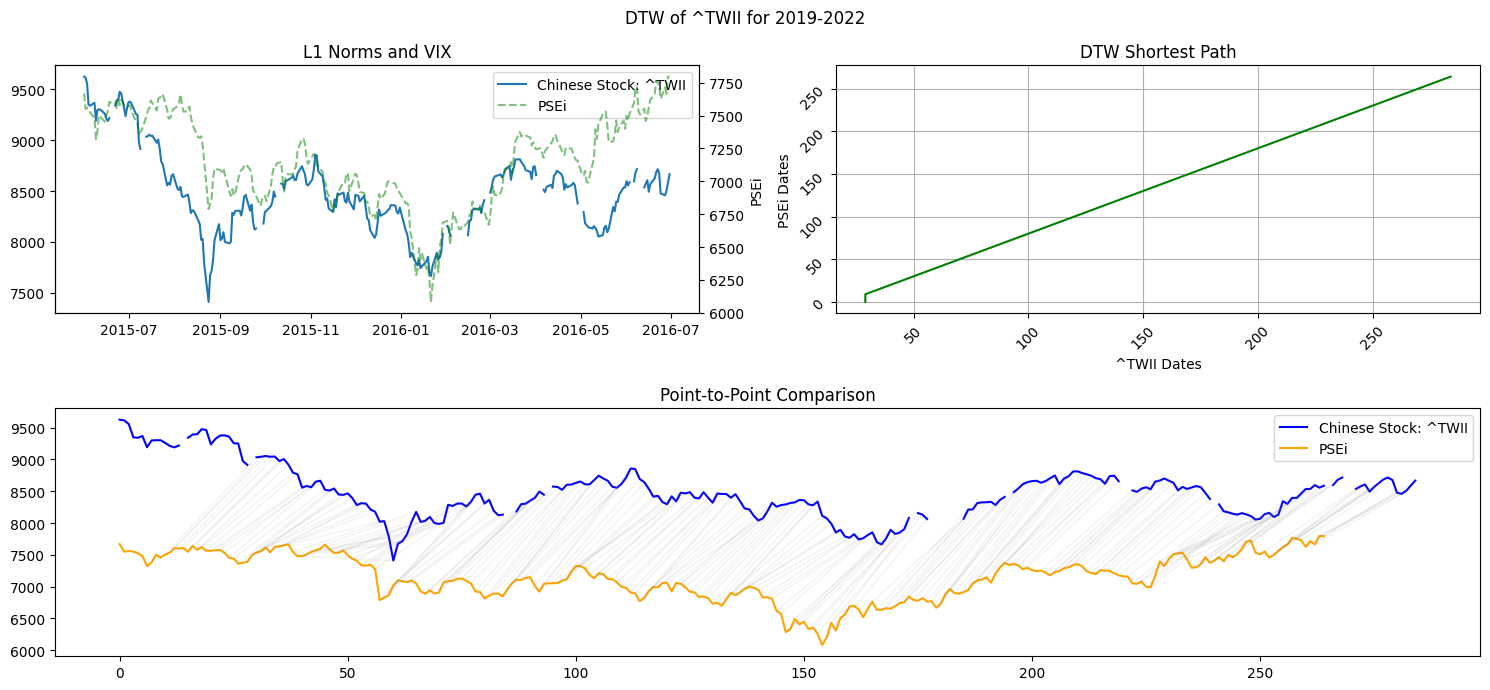

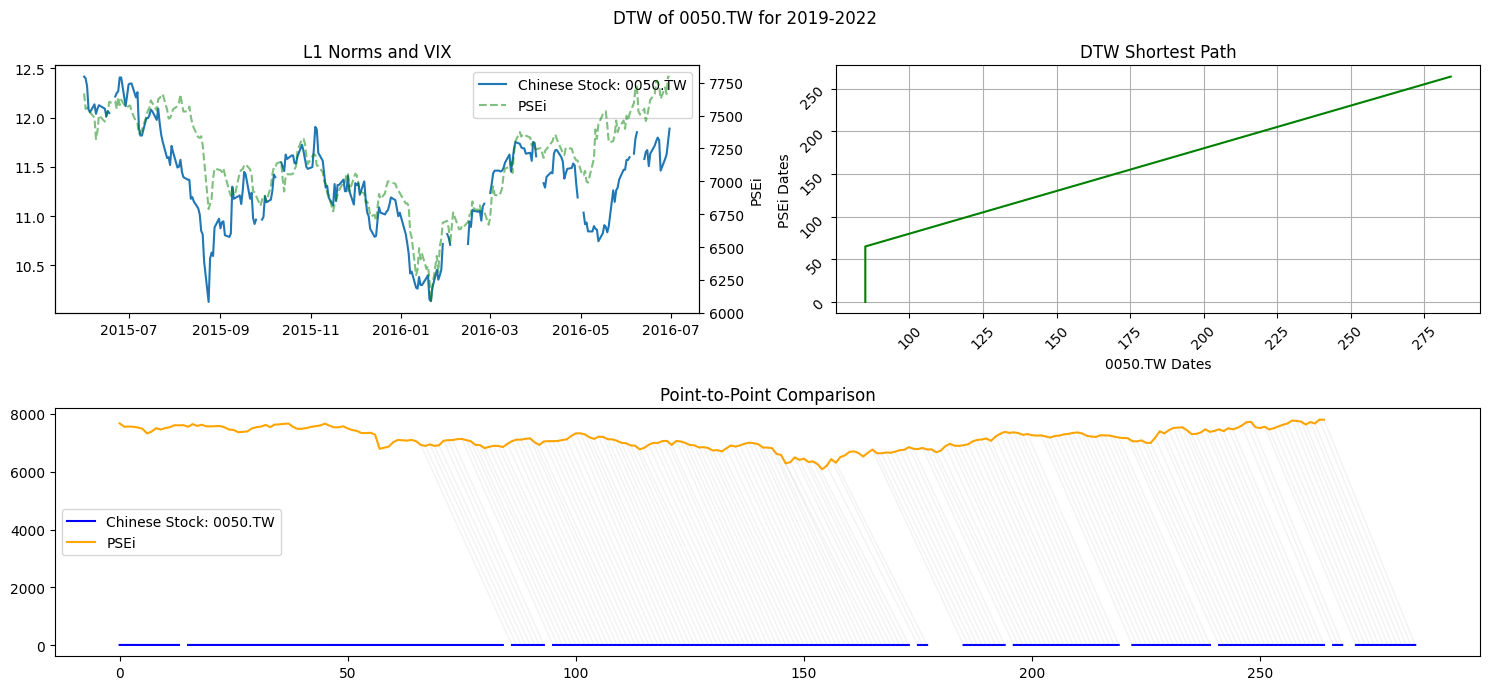

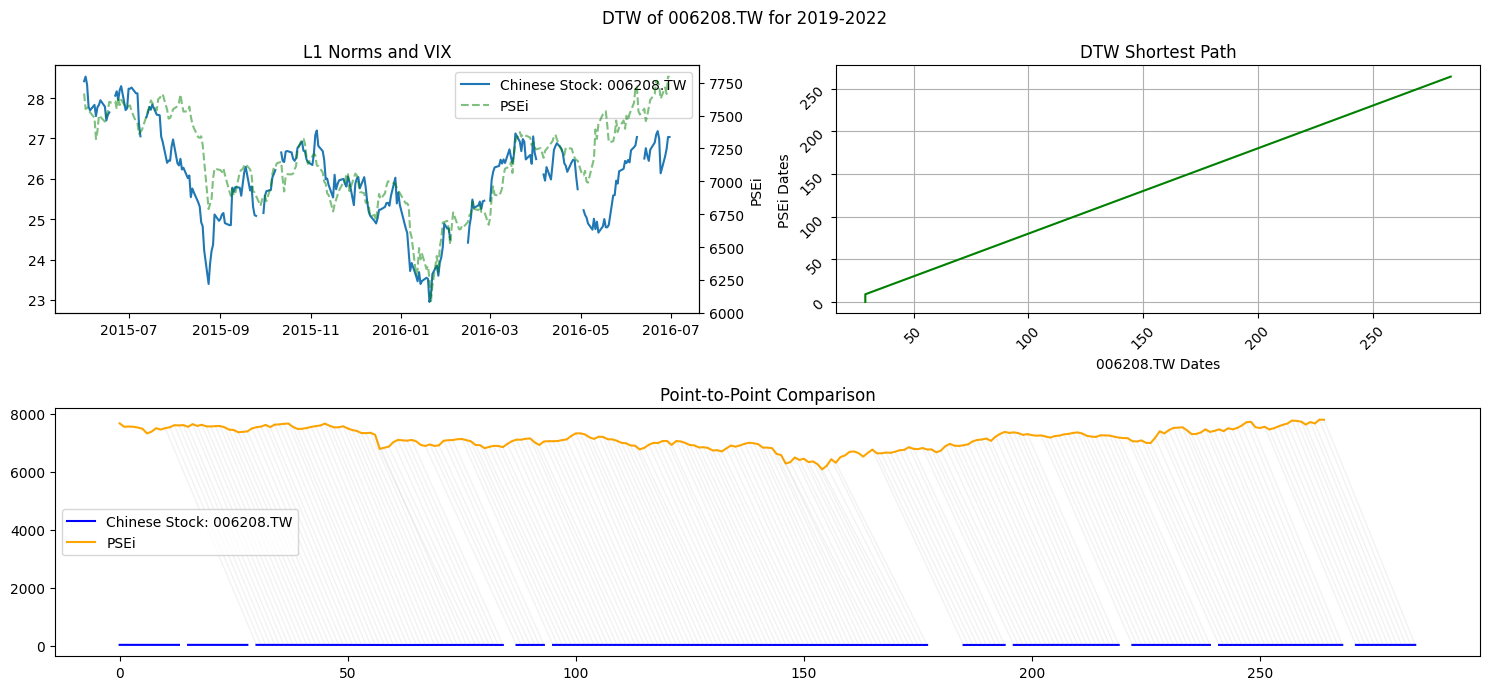

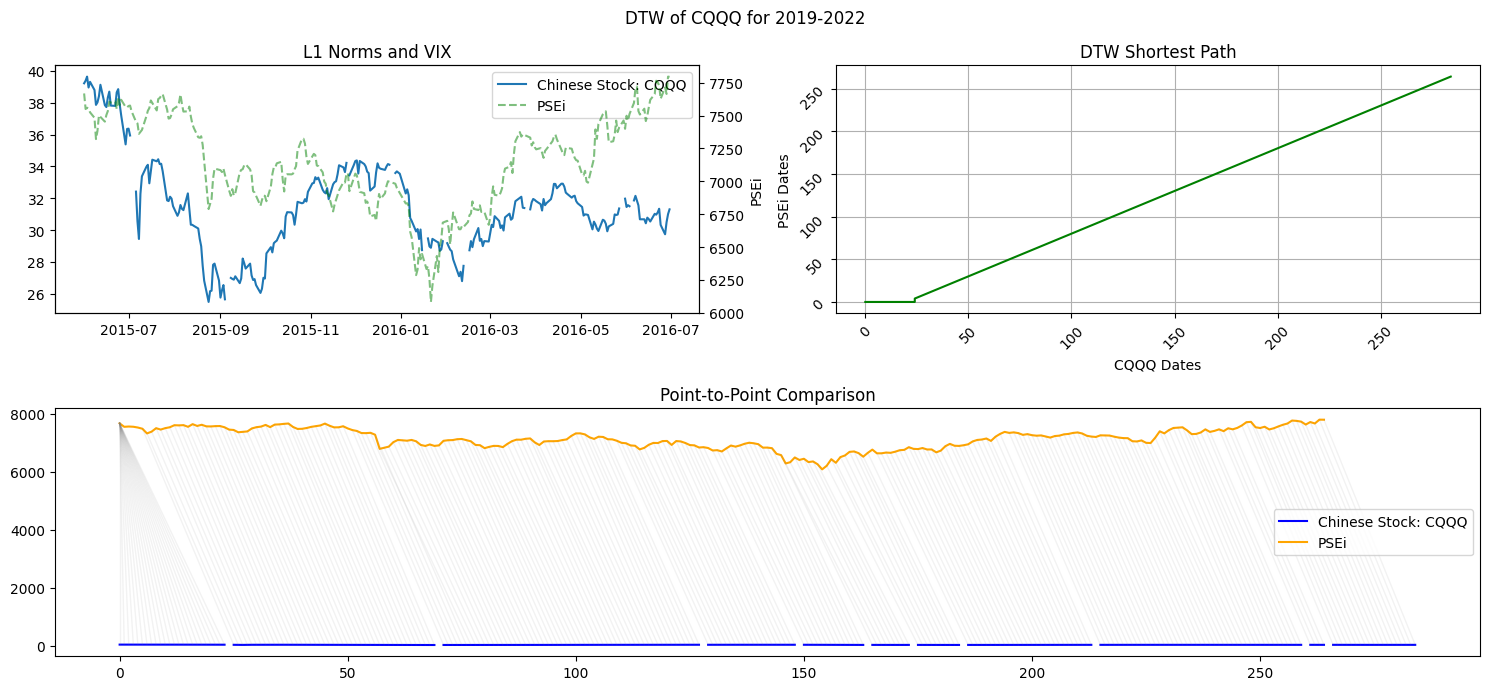

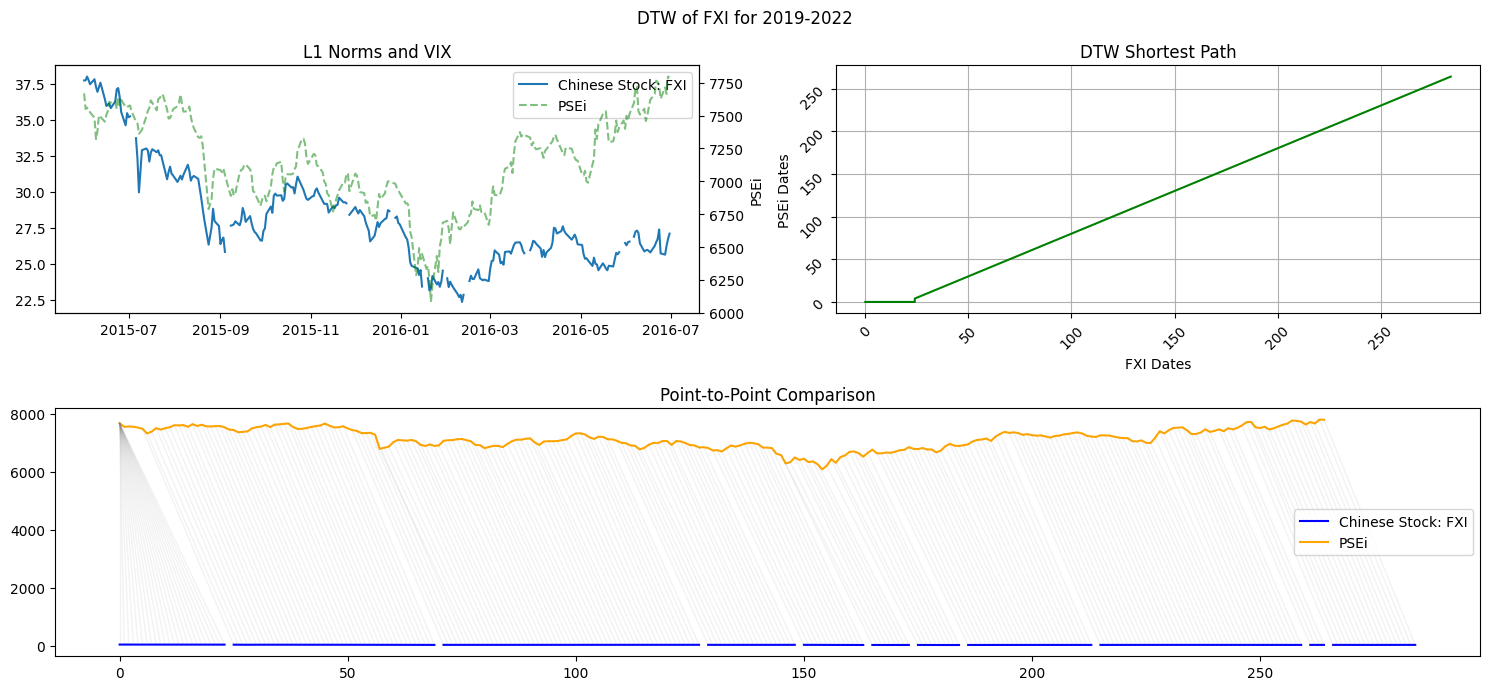

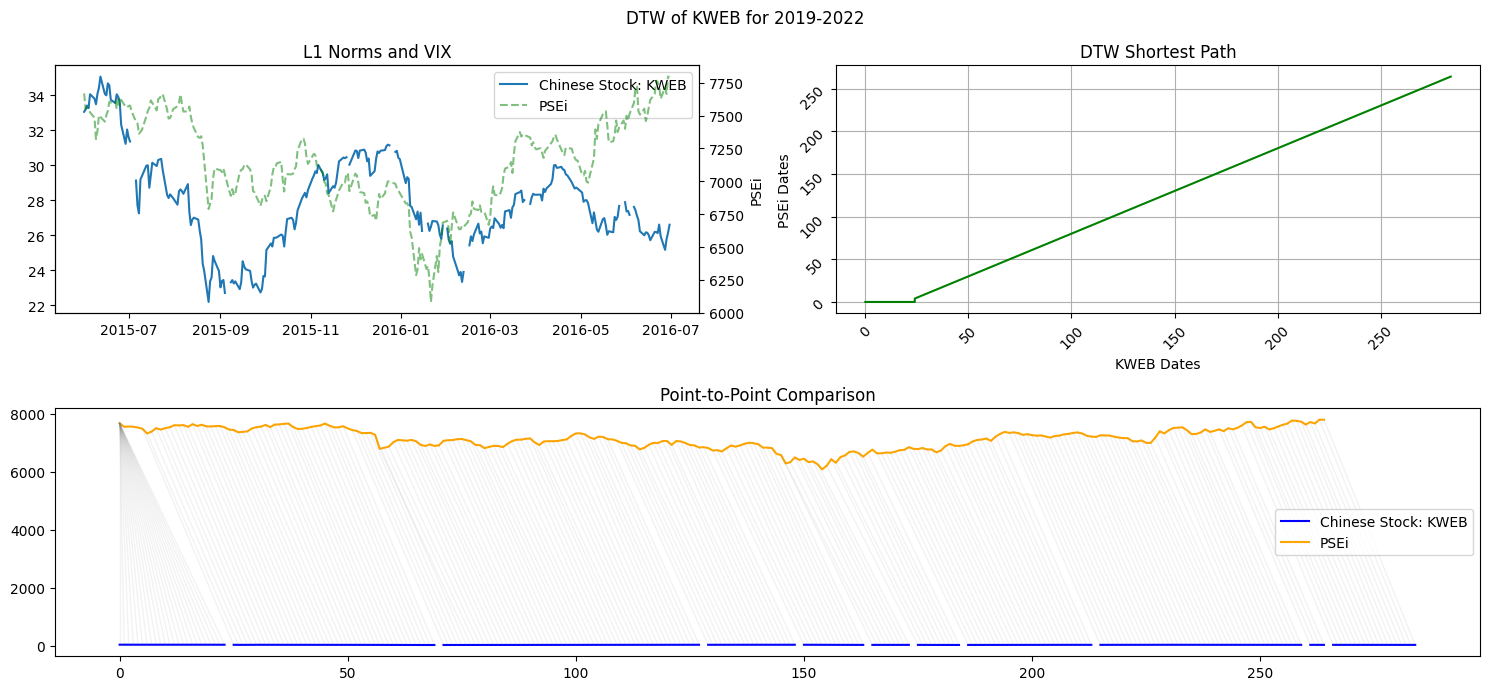

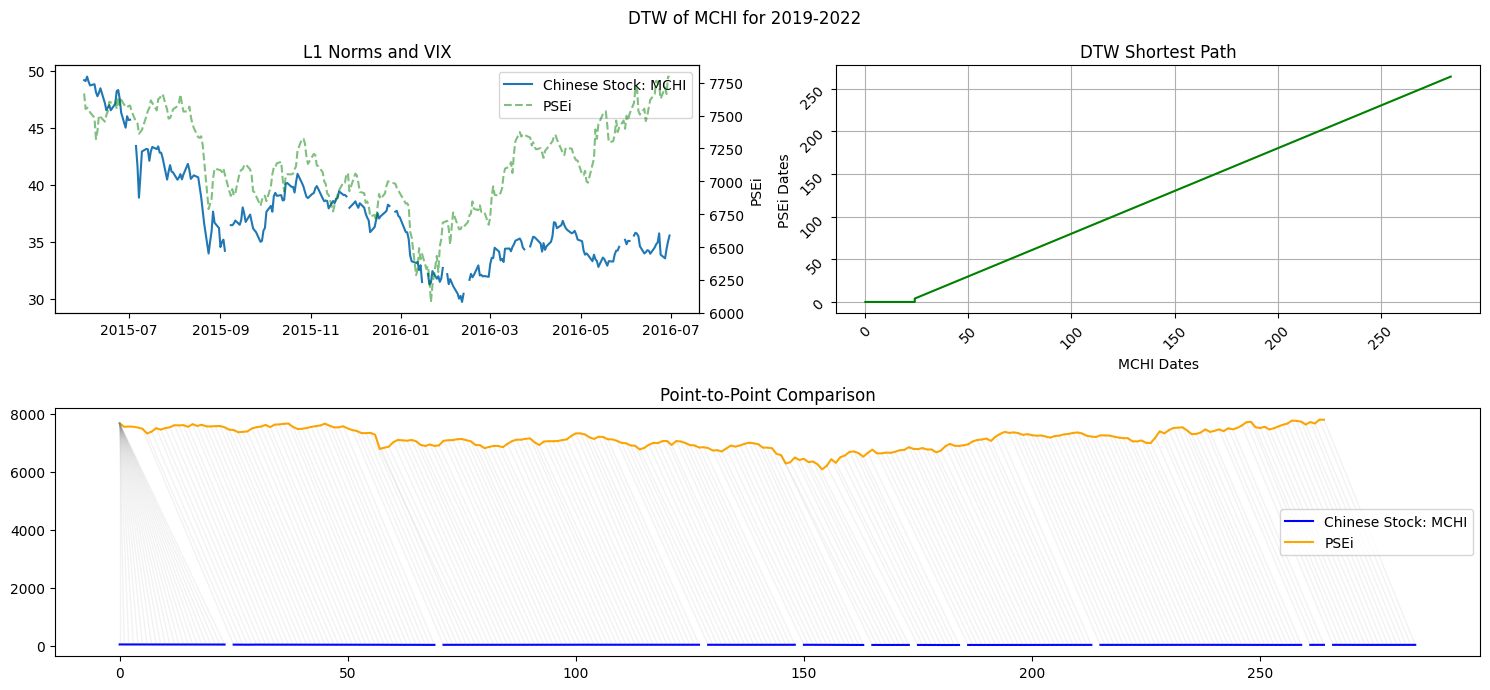

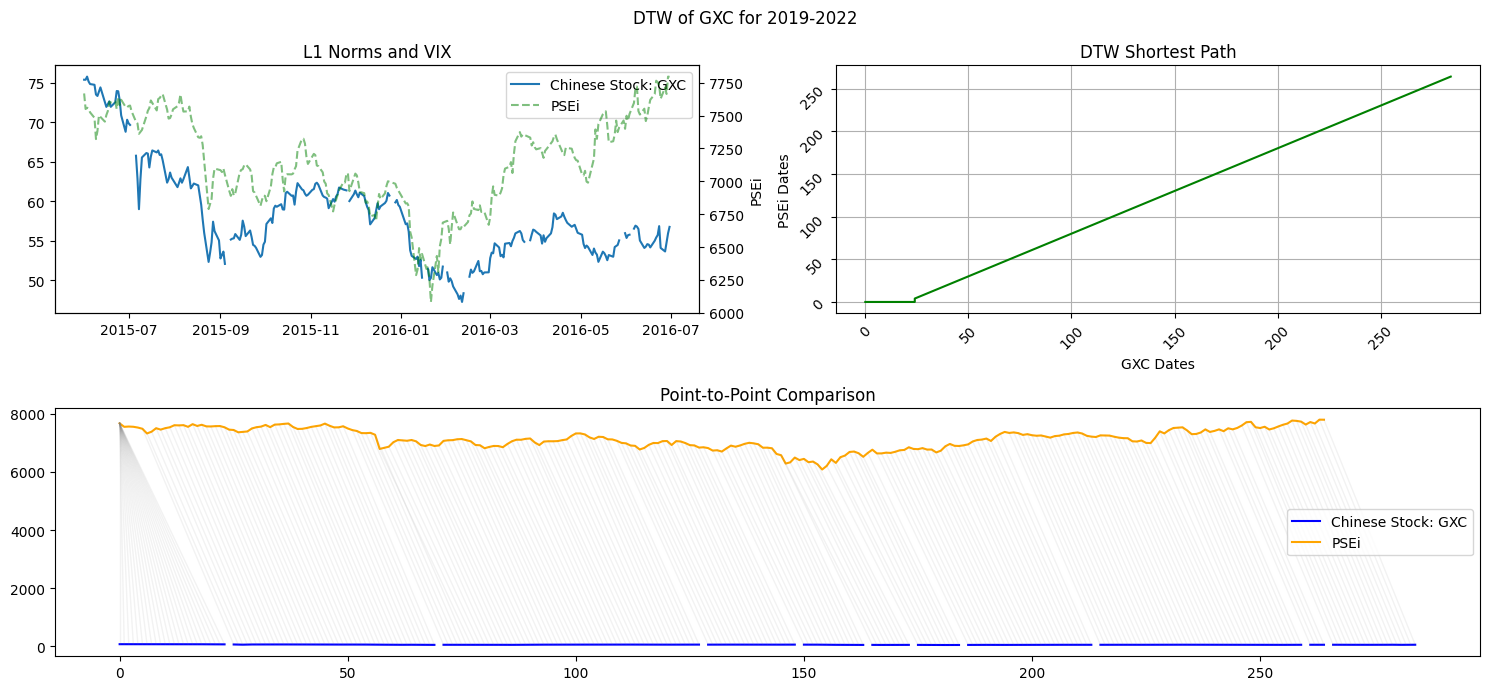

In [13]:
for col in chinese_data.columns:
    # temporary variable for data to be comapred
    chinese_compare = chinese_data[col].loc['2015-06':'2016-06']
    psei_compare = psei_data.loc['2015-06':'2016-06']
    
    # dynamic time warping
    distance, paths = dtw.warping_paths(
        chinese_compare.values, psei_compare.values, 
        use_c=False
    )
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)
    
    # plotting
    fig = plt.figure(figsize=(15, 7))
    
    # l1 norms
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.plot(chinese_compare, label=f'Chinese Stock: {col}')
    
    # vix 
    ax2 = ax1.twinx()
    ax2.plot(psei_compare, label="PSEi", alpha=0.5, color='green', linestyle='--')
    ax2.set_ylabel('PSEi')
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    ax1.set_title('L1 Norms and VIX')

    # dtw shortest path
    ax3 = plt.subplot2grid((2, 2), (0, 1))
    path = np.array(best_path)
    ax3.plot(path[:, 0], path[:, 1], color='green',)
    ax3.set_title('DTW Shortest Path')
    ax3.set_xlabel(f'{col} Dates')
    ax3.set_ylabel('PSEi Dates')
    ax3.grid(True)    
    ax3.tick_params(axis='x', rotation=45)
    ax3.tick_params(axis='y', rotation=45)

    # point to point alignment
    time_series_a = chinese_compare.values.flatten()
    time_series_b = psei_compare.values.flatten()
    
    ax4 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    ax4.plot(time_series_a, label=f'Chinese Stock: {col}', color='blue')
    ax4.plot(time_series_b, label='PSEi', color='orange')
    for a, b in best_path:
        ax4.plot(
            [a, b], [time_series_a[a], time_series_b[b]], 
            color='grey', linestyle='-', linewidth=1, alpha = 0.1
        )
    ax4.set_title('Point-to-Point Comparison')
    ax4.legend()

    title = f'DTW of {col} for 2019-2022'
    fig.suptitle(title)
    plt.tight_layout()
    plt.show() 